In [1]:
from ete3 import Tree
from Bio import Phylo
from io import StringIO
import os
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
import numpy as np
import seaborn as sns

In [3]:
from scipy.stats import spearmanr, pearsonr
from tqdm import tqdm

In [4]:

def branching_factor(tree):
    bf = []
    for i in tree.get_nonterminals():
        bf.append(len(i.clades))
    bf = np.array(bf)
    return bf[bf>1]

In [5]:
def allel_edit_distance(al1, al2):
    n = len(al1)
    diff, cnt = 0, 0
    for i in range(n):
        if (al1[i] == '_') or (al2[i] == '_'):
            continue
        cnt += 1
        if al1[i] != al2[i]:
            if (al1[i] == 0) or (al2[i] == 0) or (al1[i] == '0') or (al2[i] == '0'):
                diff += 1
            else:
                diff += 2
    return diff / cnt           

def phylogenetic_distance(tree, node1, node2):
    return tree.distance(node1, node2)

In [6]:
data_path = '/data3/wangkun/phylovelo_datasets/embryo/'

In [7]:
crispr_tree_chan = {'terminal':[], 'nonterminal':[], 'branching_factor':[], 'pearsonr':[], 'spearmanr':[]}
data_path = '/data3/wangkun/phylovelo_datasets/embryo/'
for i in [1,2,3,6]:
    with open(data_path+f'trees/embryo{i}_all.newick', 'r') as f:
        tree_nwk = f.readline()
    t = Tree(tree_nwk)
    f = StringIO(t.write())
    tree = Phylo.read(f, 'newick')
    f.close()
    crispr_tree_chan['terminal'].append(len(tree.get_terminals()))
    crispr_tree_chan['nonterminal'].append(len(tree.get_nonterminals()))
    crispr_tree_chan['branching_factor'].append(branching_factor(tree).mean())
    p_dist, ae_dist = [], []
    em = i
    if em == 2:
        alleletab = pd.read_csv(data_path + f'GSM{3302825+em}_embryo{em}a_alleleTable.txt', sep='\t', index_col=0)
        alleletab1 = pd.read_csv(data_path + f'GSM{3302826+em}_embryo{em}b_alleleTable.txt', sep='\t', index_col=0)
    else:
        if em >= 3:
            alleletab = pd.read_csv(data_path + f'GSM{3302826+em}_embryo{em}_alleleTable.txt', sep='\t', index_col=0)
        else:                                          
            alleletab = pd.read_csv(data_path + f'GSM{3302825+em}_embryo{em}_alleleTable.txt', sep='\t', index_col=0)

    for _ in tqdm(range(1000)):
        terminals = tree.get_terminals()
        c1, c2 = np.random.choice(range(len(terminals)), 2, replace=False)
        c1, c2 = terminals[c1], terminals[c2]
        p_dist.append(phylogenetic_distance(tree, c1, c2))
        try:
            al1 = alleletab.loc[f'{c1.name}-1']
        except:
            al1 = alleletab1.loc[f'{c1.name}-1']
        try:
            al2 = alleletab.loc[f'{c2.name}-1']
        except:
            al2 = alleletab1.loc[f'{c2.name}-1']
            
        
        if len(al1.shape) == 1:
            al1 = pd.DataFrame(al1).T
        if len(al2.shape) == 1:
            al2 = pd.DataFrame(al2).T
        intbc = set(al1['intBC']).intersection(set(al2['intBC']))
        all1 = ''
        all2 = ''
        for ibc in intbc:
            all1 += str(al1[al1['intBC']==ibc]['allele1'])
            all2 += str(al2[al2['intBC']==ibc]['allele1']) 
        ae_dist.append(allel_edit_distance(all1.split('_'), all2.split('_')))
    crispr_tree_chan['pearsonr'].append(pearsonr(p_dist, ae_dist)[0])
    crispr_tree_chan['spearmanr'].append(spearmanr(p_dist, ae_dist)[0])

100%|██████████| 1000/1000 [00:36<00:00, 27.23it/s]


In [8]:
crispr_tree_yang = {'terminal':[], 'nonterminal':[], 'branching_factor':[], 'pearsonr':[], 'spearmanr':[]}
data_path = '/data3/wangkun/phylovelo_datasets/KPTracer-Data/trees/'
trees = os.listdir(data_path)
trees = [i for i in trees if (i[-5:]=='e.nwk')]

for i in tqdm(trees):
    with open(data_path+i, 'r') as f:
        tree_nwk = f.readline()
    t = Tree(tree_nwk)
    f = StringIO(t.write())
    tree = Phylo.read(f, 'newick')
    f.close()
    n_nt = 0
    for j in tree.get_nonterminals():
        if len(j.clades) > 1:
            n_nt += 1
    crispr_tree_yang['terminal'].append(len(tree.get_terminals()))
    crispr_tree_yang['nonterminal'].append(n_nt)
    crispr_tree_yang['branching_factor'].append(branching_factor(tree).mean())
    charater_mat = pd.read_csv(data_path+i.replace('_tree.nwk', '_character_matrix.txt'), sep='\t', index_col=0)
    p_dist, ae_dist = [], []
    for _ in range(1000):
        terminals = tree.get_terminals()
        c1, c2 = np.random.choice(range(len(terminals)), 2, replace=False)
        c1, c2 = terminals[c1], terminals[c2]
        p_dist.append(phylogenetic_distance(tree, c1, c2))
        ae_dist.append(allel_edit_distance(charater_mat.loc[c1.name], charater_mat.loc[c2.name]))
    crispr_tree_yang['pearsonr'].append(pearsonr(p_dist, ae_dist)[0])
    crispr_tree_yang['spearmanr'].append(spearmanr(p_dist, ae_dist)[0])

  0%|          | 0/85 [00:00<?, ?it/s]/tmp/ipykernel_216160/1832192097.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if (al1[i] == '_') or (al2[i] == '_'):
/tmp/ipykernel_216160/1832192097.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if al1[i] != al2[i]:
/tmp/ipykernel_216160/1832192097.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if (al1[i] == 0) or (al2[i] == 0) or (al1[i] == '0') or (al2[i] == '0'):
  1%|     

 11%|█         | 9/85 [00:43<08:14,  6.50s/it]/tmp/ipykernel_216160/1832192097.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if (al1[i] == '_') or (al2[i] == '_'):
/tmp/ipykernel_216160/1832192097.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if al1[i] != al2[i]:
/tmp/ipykernel_216160/1832192097.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if (al1[i] == 0) or (al2[i] == 0) or (al1[i] == '0') or (al2[i] == '0'):
 1

 21%|██        | 18/85 [01:09<03:40,  3.29s/it]/tmp/ipykernel_216160/1832192097.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if (al1[i] == '_') or (al2[i] == '_'):
/tmp/ipykernel_216160/1832192097.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if al1[i] != al2[i]:
/tmp/ipykernel_216160/1832192097.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if (al1[i] == 0) or (al2[i] == 0) or (al1[i] == '0') or (al2[i] == '0'):
 

 32%|███▏      | 27/85 [01:30<02:07,  2.20s/it]/tmp/ipykernel_216160/1832192097.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if (al1[i] == '_') or (al2[i] == '_'):
/tmp/ipykernel_216160/1832192097.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if al1[i] != al2[i]:
/tmp/ipykernel_216160/1832192097.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if (al1[i] == 0) or (al2[i] == 0) or (al1[i] == '0') or (al2[i] == '0'):
 

 42%|████▏     | 36/85 [01:50<01:34,  1.92s/it]/tmp/ipykernel_216160/1832192097.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if (al1[i] == '_') or (al2[i] == '_'):
/tmp/ipykernel_216160/1832192097.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if al1[i] != al2[i]:
/tmp/ipykernel_216160/1832192097.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if (al1[i] == 0) or (al2[i] == 0) or (al1[i] == '0') or (al2[i] == '0'):
 

 53%|█████▎    | 45/85 [02:41<06:28,  9.72s/it]/tmp/ipykernel_216160/1832192097.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if (al1[i] == '_') or (al2[i] == '_'):
/tmp/ipykernel_216160/1832192097.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if al1[i] != al2[i]:
/tmp/ipykernel_216160/1832192097.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if (al1[i] == 0) or (al2[i] == 0) or (al1[i] == '0') or (al2[i] == '0'):
 

 64%|██████▎   | 54/85 [03:25<03:25,  6.62s/it]/tmp/ipykernel_216160/1832192097.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if (al1[i] == '_') or (al2[i] == '_'):
/tmp/ipykernel_216160/1832192097.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if al1[i] != al2[i]:
/tmp/ipykernel_216160/1832192097.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if (al1[i] == 0) or (al2[i] == 0) or (al1[i] == '0') or (al2[i] == '0'):
 

 74%|███████▍  | 63/85 [04:05<01:19,  3.61s/it]/tmp/ipykernel_216160/1832192097.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if (al1[i] == '_') or (al2[i] == '_'):
/tmp/ipykernel_216160/1832192097.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if al1[i] != al2[i]:
/tmp/ipykernel_216160/1832192097.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if (al1[i] == 0) or (al2[i] == 0) or (al1[i] == '0') or (al2[i] == '0'):
 

 85%|████████▍ | 72/85 [05:22<04:19, 19.95s/it]/tmp/ipykernel_216160/1832192097.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if (al1[i] == '_') or (al2[i] == '_'):
/tmp/ipykernel_216160/1832192097.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if al1[i] != al2[i]:
/tmp/ipykernel_216160/1832192097.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if (al1[i] == 0) or (al2[i] == 0) or (al1[i] == '0') or (al2[i] == '0'):
 

 95%|█████████▌| 81/85 [06:58<00:29,  7.40s/it]/tmp/ipykernel_216160/1832192097.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if (al1[i] == '_') or (al2[i] == '_'):
/tmp/ipykernel_216160/1832192097.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if al1[i] != al2[i]:
/tmp/ipykernel_216160/1832192097.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if (al1[i] == 0) or (al2[i] == 0) or (al1[i] == '0') or (al2[i] == '0'):
 

In [9]:
eTRACERtree = pd.read_csv('/syn1/liangzhen/jinhua_jilab_project/result/DNA_Amplicon/trees/merge_all_experiments/T2_and_T3/polytomy/branch_index.list', sep='\t')
eTRACER_tree = {'terminal':[], 'nonterminal':[], 'branching_factor':[], 'pearsonr':[], 'spearmanr':[]}
data_path = '/syn1/liangzhen/jinhua_jilab_project/result/DNA_Amplicon/trees/merge_all_experiments/T2_and_T3/polytomy/'
for i in tqdm(eTRACERtree['sample']):
    if i == 'C1':
        with open(data_path+'C1_downsampling5k/C1_downsampling5k.phy.treefile', 'r') as f:
            tree_nwk = f.readline()        
    else:
        with open(data_path+'cell_mutation_matrix-'+f'{i}.phy.treefile', 'r') as f:
            tree_nwk = f.readline()
    cls = tree_nwk.split(':0.00000)')
    for j, cl in enumerate(cls[:-1]):
        success = 0
        jj = j
        while not success:
            try:
                k = -cls[jj][::-1].index('(')
                new = cls[jj][:k-1] + cls[jj][k:]
                assert ')' not in cls[jj][k:]
                cls[jj] = new
                success = 1
            except:
                jj -= 1
        assert success == 1
    t = Tree(''.join(cls))
    f = StringIO(t.write())
    tree = Phylo.read(f, 'newick')
    f.close()
    eTRACER_tree['terminal'].append(len(tree.get_terminals()))
    eTRACER_tree['nonterminal'].append(len(tree.get_nonterminals()))
    eTRACER_tree['branching_factor'].append(branching_factor(tree).mean())
    if i == 'C1':
        alltab = pd.read_csv(data_path+'C1_downsampling5k/C1_downsampling5k.phy', sep='\t', index_col=0)
    else:
        alltab = pd.read_csv(data_path+'cell_mutation_matrix-'+f'{i}.phy', sep='\t', index_col=0)
    p_dist, ae_dist = [], []
    for _ in range(1000):
        terminals = tree.get_terminals()
        c1, c2 = np.random.choice(range(len(terminals)), 2, replace=False)
        c1, c2 = terminals[c1], terminals[c2]
        p_dist.append(phylogenetic_distance(tree, c1, c2))
        ae_dist.append(allel_edit_distance(alltab.loc[c1.name].iloc[0], alltab.loc[c2.name].iloc[0]))
    eTRACER_tree['pearsonr'].append(pearsonr(p_dist, ae_dist)[0])
    eTRACER_tree['spearmanr'].append(spearmanr(p_dist, ae_dist)[0])

100%|██████████| 103/103 [02:50<00:00,  1.65s/it]


/tmp/ipykernel_216160/1123938835.py:40: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(data=df, x="Group", y="Branching index", ax=ax,
/home/liangzhen/anaconda3/envs/cellrank2/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/liangzhen/anaconda3/envs/cellrank2/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Crispr tree (Chan 2019) vs. Crispr tree (Yang 2022): Mann-Whitney-Wilcoxon test two-sided, P_val:2.662e-01 U_stat=1.120e+02
Crispr tree (Yang 2022) vs. eTRACER tree: Mann-Whitney-Wilcoxon test two-sided, P_val:1.366e-20 U_stat=9.225e+02
Crispr tree (Chan 2019) vs. eTRACER tree: Mann-Whitney-Wilcoxon test two-sided, P_val:7.838e-04 U_stat=1.000e+00


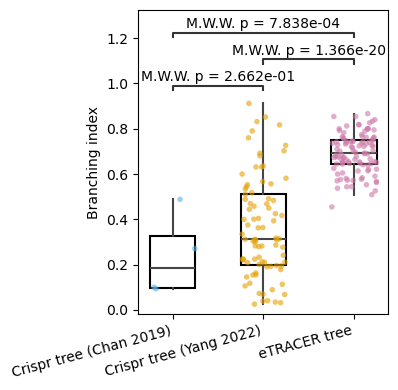

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statannotations.Annotator import Annotator
from scipy.stats import ttest_ind


data = {
    "Crispr tree (Chan 2019)": np.array(crispr_tree_chan['nonterminal']) / (np.array(crispr_tree_chan['terminal'])-1),
    "Crispr tree (Yang 2022)": np.array(crispr_tree_yang['nonterminal']) / (np.array(crispr_tree_yang['terminal'])-1),
    "eTRACER tree": np.array(eTRACER_tree['nonterminal']) / (np.array(eTRACER_tree['terminal'])-1)
}

df = pd.DataFrame([(key, val) for key, values in data.items() for val in values], columns=["Group", "Branching index"])


palette = {
    "Crispr tree (Chan 2019)": "#56B4E9",
    "Crispr tree (Yang 2022)": "#E69F00",
    "eTRACER tree": "#CC79A7"
}


pairs = [
    ("Crispr tree (Chan 2019)", "Crispr tree (Yang 2022)"),
    ("Crispr tree (Chan 2019)", "eTRACER tree"),
    ("Crispr tree (Yang 2022)", "eTRACER tree")
]


plt.rcParams['pdf.fonttype'] = 42
fig, ax = plt.subplots(figsize=(4, 4))

sns.boxplot(data=df, x="Group", y="Branching index", ax=ax,
            boxprops=dict(facecolor='none', edgecolor='black'),
            width=0.5, fliersize=0, capprops=dict(visible=False),
            palette=palette)

sns.stripplot(data=df, x="Group", y="Branching index", ax=ax,
              size=4, jitter=0.25, alpha=0.6,
              palette=palette)


annotator = Annotator(ax, pairs, data=df, x="Group", y="Branching index")
annotator.configure(test="Mann-Whitney", text_format="full", loc="inside", comparisons_correction=None)
annotator.apply_and_annotate()

ax.set_ylabel("Branching index")
ax.set_xlabel("")
ax.set_xticklabels(ax.get_xticklabels(), rotation=15, ha='right')

plt.tight_layout()
plt.savefig('/syn1/liangzhen/jinhua_jilab_project/result/Figures/Figure2/branch_index.pdf')
plt.show()
